In [1]:
import numpy as np
import os

from tqdm.notebook import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18, 12)

from Bio import SeqIO, Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceCalculator
from Bio.Phylo.Consensus import *

import networkx as nx

import toytree
import toyplot
import toyplot.png

np.random.seed(7)

In [2]:
NT = 1000
mr_per_genome_per_year = 1.947 * 10**-4 # (Cabrera V. M., 2021)
mtDNA_length = 16559

In [3]:
def read_mulitple_write_to_one(dirs=['folderWithFastaFiles/'],
                               output_file='combined.fasta',
                               rename_after_file_name=True):
    """
    Reads in multiple fasta files form multiple folders, writes all to one fasta file.

    Parameters
    ----------
    dirs : List[Str]
        directories with *.fasta files
    output_file : Str
        Name of output file
    rename_after_file_name: Bool
        Substitute fasta id with names of the input files

    Returns
    -------
    read_mulitple_write_to_one : returns an instance of read_mulitple_write_to_one.
    """

    all_records = []

    for directory in dirs:
        records = []
        for record in tqdm(os.listdir(directory)):
            records.append(SeqIO.read(directory + record, "fasta"))

        if rename_after_file_name:
            _ = [
                setattr(record, 'id',
                        name.replace('.fasta', '').replace(' ', '_'))
                for name, record in zip(os.listdir(directory), records)
            ]

        all_records.extend(records)

    SeqIO.write(all_records, output_file, "fasta")

    return read_mulitple_write_to_one

In [4]:
def run_mafft_docker_container(container_name='staphb/mafft',
                               settings_string = '--auto',
                               input_file = 'unalaigned.fasta',
                               output_file = 'alaigned.fasta'):
    """
    Runs a typical MAFFT aligner Docker container from Docker Hub.
    You need a running Docker daemon.
    If the container is not downloaded automatically, use docker pull command.

    Parameters
    ----------
    container_name : Str
        Container name, if the container is not present, !it might be downloaded automatically!
    settings_string : Str
        arguments for the aligner, default --auto
    input_file : Str
    output_file : Str
    
    Returns
    -------
    exit_code : Int
        an exit code, 0 - no error exit
    """
    exit_code = os.system(f"docker run --rm -v {os.getcwd()}:/data {container_name} mafft {settings_string} {input_file} > {output_file}")
    return exit_code

In [5]:
def run_fasttree_docker_container(container_name='pegi3s/fasttree',
                               settings_string = '-boot 1000 -nt',
                               input_file = 'aligned.fasta',
                               output_file = 'output.tre'):
    """
    Runs a typical FastTree Docker container from Docker Hub.
    You need a running Docker daemon.
    If the container is not downloaded automatically, use docker pull command.

    Parameters
    ----------
    container_name : Str
        Container name, if the container is not present, !it might be downloaded automatically!
    settings_string : Str
        arguments for the aligner, default --auto
    input_file : Str
    output_file : Str
    
    Returns
    -------
    exit_code : Int
        an exit code, 0 - no error exit
    """
    
    exit_code = os.system(f'docker run --rm -v {os.getcwd()}:/data {container_name} bash -c "FastTree {settings_string} /data/{input_file} > /data/{output_file}"')
    return exit_code

In [6]:
def draw_tree_to_png(input_tree, outgroup, output_png, width=1400,height=1000):
    """
    Draws tree using toytree module.

    Parameters
    ----------
    input_tree : Str
        Path to tree in newick
    outgroup : List[Str]
    output_png : Str
        Name of output file

    Returns
    -------
     : draw_tree_to_png
    """
    
    
    style = {
        "layout": 'd',
        "edge_type": 'p',
        "edge_style": {
            "stroke": toytree.colors[2],
            "stroke-width": 4.5,
        },
        "tip_labels_align": True,
        "tip_labels_style": {
            "font-size": "22px"
        },
        "node_labels": True,
        "node_sizes": 0,
        "node_colors": toytree.colors[0],
        "node_labels_style": {
            "font-size": "20px"
        }
    }
    
    T = Phylo.read(input_tree, 'newick')
    T.root_with_outgroup(outgroup)
    tre = toytree.tree(T.format('newick'))

    colors = {}
    leaf_colors = []
    for leaf in tre.get_tip_labels():
        if leaf[0] in colors.keys():
            leaf_colors.append(colors[leaf[0]])
        else:
            colors[leaf[0]] = mpl.colors.cnames[list(mpl.colors.cnames.keys())[np.random.randint(0, len(mpl.colors.cnames.keys()) - 1)]]
            leaf_colors.append(colors[leaf[0]])

    canvas, axes, mark = tre.draw(width=1400,height=1000,tip_labels_colors=leaf_colors, **style)

    toyplot.png.render(canvas, output_png)
    
    return draw_tree_to_png

In [7]:
def build_identity_tree(msa='aligned.fasta',
                        outgroup=['L1c1d_Central_African'],
                        method='nj'):
    """
    Build identity tree from msa.

    Parameters
    ----------
    msa : Str
        Path to msa.fasta
    outgroup : List[Str] or Str or None
        List of ids to use as outgroup
    method : Str
        nj or upgma


    Returns
    -------
    tree : Bio.Phylo.BaseTree.Tree
    """

    msa = AlignIO.read(msa, 'fasta')

    calculator = DistanceCalculator('identity')
    dm = calculator.get_distance(msa)

    if method == 'upgma':
        constructor = DistanceTreeConstructor(method='upgma')
        tree = constructor.upgma(dm)
    else:
        constructor = DistanceTreeConstructor(method='nj')
        tree = constructor.nj(dm)

    if outgroup:
        tree.root_with_outgroup(outgroup)

    tree.ladderize()
    
    # name inner nodes if not named
    K = [1]
    for node in tree.get_nonterminals():
        if not node.name:

            K[0] += 1
            node.name = 'Inner' + str(K[0])

    return tree

In [8]:
def get_constant_years_from_identity(tree, a, b, mtDNA_length = 6559, mrate = 1.947 * 10**-4):
    
    """
    Traverses the tree to estimate the age 
    from node a to node b in Bio.Phylo.BaseTree.Tree, 
    using branch lengths.

    Parameters
    ----------
    tree : Bio.Phylo.BaseTree.Tree
    a : Str
        start node name
    b : Str
        target node name
    mtDNA_length : Int
    mrate : Float
        mutation rate per genome per year
        

    Returns
    -------
    eage : Float
        estimated age
    """
    
    tree = Phylo.to_networkx(tree)
    
    for node in tree.nodes:
        if str(node).strip() == a:
            a = node
        elif str(node) == b:
            b = node

    path = nx.shortest_path(tree, a, b)
    # print(path)
    eage = sum([p.branch_length for p in path[:]]) * mtDNA_length / 2 / mrate
    return eage

In [9]:
def get_average_age_from_to_all_terminals(tree, terminals, start_node):
    """
    Computes average estimated age from given node to given terminals

    Parameters
    ----------
    tree : Bio.Phylo.BaseTree.Tree
    terminals : List[Str]
        names of terminal nodes
    start_node : Str
        start node name

    Returns
    -------
    avg_eage : Float
        average estimated age
    """

    eages = []
    for tnode in terminals:
        try:
            eages.append(
                get_constant_years_from_identity(tree, start_node, tnode))
        except:
            pass

    avg_eage = np.mean([ea for ea in eages if ea > 0])
    return avg_eage

# Modern humans

  0%|          | 0/45 [00:00<?, ?it/s]

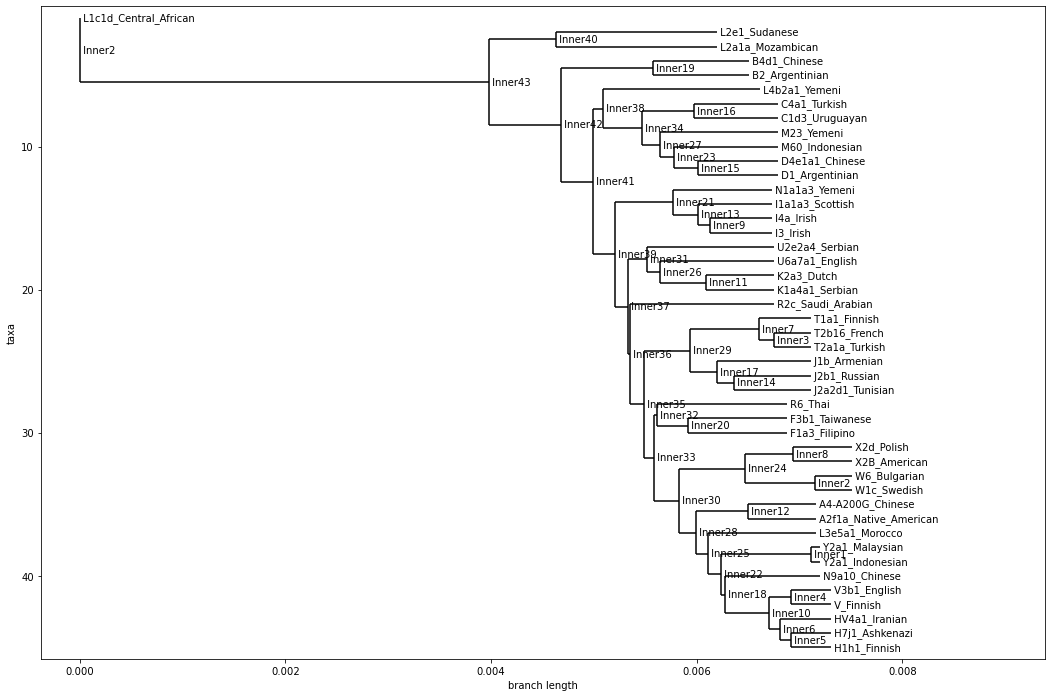

In [10]:
# combine
read_mulitple_write_to_one(dirs=['Human/'], output_file='unalaigned1.fasta');

# align
run_mafft_docker_container(input_file='unalaigned1.fasta', output_file='alaigned1.fasta')

# build tree
run_fasttree_docker_container(input_file='alaigned1.fasta',
                              settings_string = f'-boot {NT} -gtr -nt', # -rawdist
                              output_file='tree1.tre')
# define outgroup
outgroup1 = ['L1c1d_Central_African']

# save tree to png
draw_tree_to_png('tree1.tre', outgroup1, 'tree1.png')

# build identity tree
tree1 = build_identity_tree('alaigned1.fasta', outgroup1, method='upgma')
terminals1 = [t.name for t in tree1.get_terminals()]

# draw tree
Phylo.draw(tree1)

In [11]:
# how old is Mitochondrial Eve ?
get_average_age_from_to_all_terminals(tree1, terminals1[1:], 'Inner2')

117343.84796435916

In [17]:
# How old is the most recent ancestor of all non-Africans?
get_average_age_from_to_all_terminals(tree1, terminals1, 'Inner42')

50956.4018011933

# Modern Humans, Neanderthal , Denisovan

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

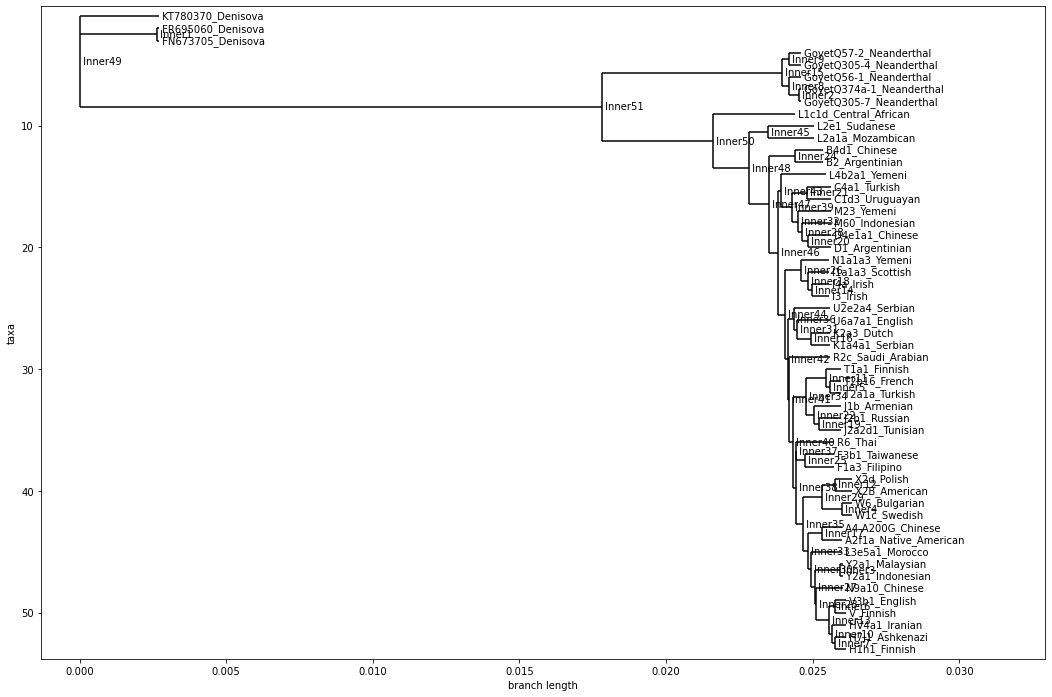

In [13]:
# combine
read_mulitple_write_to_one(dirs=['Human/', 'Neanderthal/', 'Denisova/'], output_file='unalaigned2.fasta');

# align
run_mafft_docker_container(input_file='unalaigned2.fasta', output_file='alaigned2.fasta')

# build tree
run_fasttree_docker_container(input_file='alaigned2.fasta',
                              settings_string = f'-boot {NT} -gtr -nt', # -rawdist
                              output_file='tree2.tre')
# define outgroup
outgroup2 = ['FN673705_Denisova', 'FR695060_Denisova', 'KT780370_Denisova']

# save tree to png
draw_tree_to_png('tree2.tre', outgroup2, 'tree2.png')

# build identity tree
tree2 = build_identity_tree('alaigned2.fasta', outgroup2, method='upgma')
terminals2 = [t.name for t in tree2.get_terminals()]

# draw tree
Phylo.draw(tree2)

In [14]:
# how old is Mitochondrial Eve ?
get_average_age_from_to_all_terminals(tree2, terminals2[8:], 'Inner50')

134091.2627665986

In [15]:
# How old is the most recent ancestor of all non-Africans?
get_average_age_from_to_all_terminals(tree2, terminals2[8:], 'Inner47')

50928.76151574153

In [16]:
# What is the age of the most recent Neanderthal-modern human ancestor?
get_average_age_from_to_all_terminals(tree2, terminals2[8:], 'Inner51')

434055.01311020047

1. Kinene T. [et al]. Rooting Trees, Methods for // Encyclopedia of Evolutionary Biology [Online]. URL: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7149615/.

2. Archives: mtDNA Stories // haplogroup.org [Online]. URL: https://haplogroup.org/mtdna/.

3. Cabrera V. M. Human molecular evolutionary rate, time dependency and transient polymorphism effects viewed through ancient and modern mitochondrial DNA genomes // Scientific Reports [Online]. URL: https://doi.org/10.1038/s41598-021-84583-1.

4. Thomson J. Humans did come out of Africa, says DNA // Nature [Online]. URL: https://doi.org/10.1038/news001207-8.